<center>
    <img src="https://gitlab.com/ibm/skills-network/courses/placeholder101/-/raw/master/labs/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [1]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
# Cross-Validation object
from sklearn.model_selection import RepeatedKFold
# For general sklearn access
import sklearn
import sklearn.feature_selection

This function is to plot the confusion matrix.


In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['will not land', 'will land'])
    ax.yaxis.set_ticklabels(['did not land', 'did land']);

## Load the dataframe


Load the data


In [3]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv')

data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [4]:
features = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')

X = features.copy()

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_3.csv')

X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [5]:
Y = data['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

In [6]:
df_results = pd.DataFrame(index=['Logistic Regression','Support Vector Machine','Decision Tree','K Nearest Neighbor'],
                          columns=['Best Parameters','Train Accuracy','Test Accuracy'])

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [7]:
# students get this 
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)
# NOTE: the scaling should be done AFTER splitting to avoid biasing the input; a Pipeline is useful for this.

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [9]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [10]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'], # l1 lasso l2 ridge
             'solver':['lbfgs'] # ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
            }
lr=LogisticRegression()

In [11]:
logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters, scoring=None, n_jobs=1, cv=10)
logreg_cv.fit(X_train, Y_train);
# Note this should be improved by explicitly choosing the crossvalidator object e.g. KFold, choosing a problem-derived score

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [12]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


In [13]:
df_results.iloc[0,0] = [logreg_cv.best_params_]
df_results.iloc[0,1] = logreg_cv.best_score_

## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [14]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

In [15]:
df_results.iloc[0,2] = logreg_cv.score(X_test, Y_test)

Lets look at the confusion matrix:


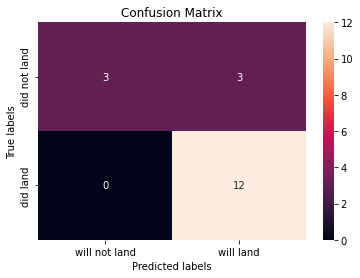

In [16]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [17]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [18]:
svm_cv = GridSearchCV(estimator=svm, param_grid=parameters, scoring=None, n_jobs=1, cv=10)
svm_cv.fit(X_train, Y_train);

In [19]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


In [20]:
df_results

,Best Parameters,Train Accuracy,Test Accuracy
Logistic Regression,"[{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}]",0.846429,0.833333
Support Vector Machine,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN
K Nearest Neighbor,NaN,NaN,NaN


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [21]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


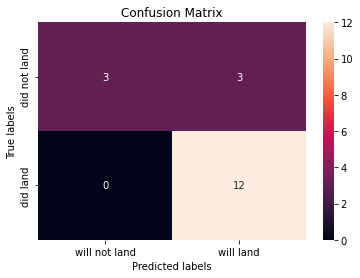

In [22]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

These results are identical to that of the logistic regression

In [23]:
ii = 1
gg = svm_cv
df_results.iloc[ii,0] = [gg.best_params_]
df_results.iloc[ii,1] = gg.best_score_
df_results.iloc[ii,2] = gg.score(X_test, Y_test)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [24]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [25]:
tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, scoring=None, n_jobs=1, cv=10)
tree_cv.fit(X_train, Y_train);

In [26]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.8767857142857143


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [27]:
tree_cv.score(X_test, Y_test)

0.7777777777777778

We can plot the confusion matrix


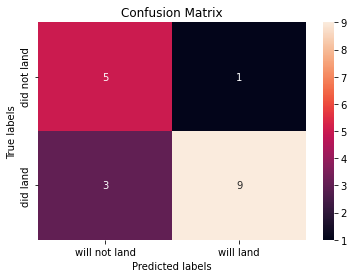

In [28]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

The decision tree is slightly better with false positives, but much worse with false negatives.

In [29]:
ii = 2
gg = tree_cv
df_results.iloc[ii,0] = [gg.best_params_]
df_results.iloc[ii,1] = gg.best_score_
df_results.iloc[ii,2] = gg.score(X_test, Y_test)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [30]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [31]:
knn_cv = GridSearchCV(estimator=KNN, param_grid=parameters, scoring=None, n_jobs=1, cv=10)
knn_cv.fit(X_train, Y_train);

In [32]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [33]:
knn_cv.score(X_test,Y_test)

0.8333333333333334

We can plot the confusion matrix


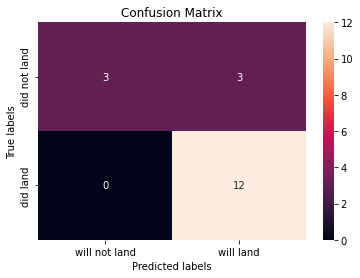

In [34]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

The K-Nearest Neighbors model is similar to the first two.

In [35]:
ii = 3
gg = knn_cv
df_results.iloc[ii,0] = [gg.best_params_]
df_results.iloc[ii,1] = gg.best_score_
df_results.iloc[ii,2] = gg.score(X_test, Y_test)

## TASK  12


Find the method performs best:


The Logistic Regression, Support Vector Machine, and K-Nearest Neighbors models perform identically and much better than the Decision Tree model on the single test/train split set considered.

In [36]:
df_results

,Best Parameters,Train Accuracy,Test Accuracy
Logistic Regression,"[{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}]",0.846429,0.833333
Support Vector Machine,"[{'C': 1.0, 'gamma': 0.03162277660168379, 'ker...",0.848214,0.833333
Decision Tree,"[{'criterion': 'gini', 'max_depth': 10, 'max_f...",0.876786,0.777778
K Nearest Neighbor,"[{'algorithm': 'auto', 'n_neighbors': 10, 'p':...",0.848214,0.833333


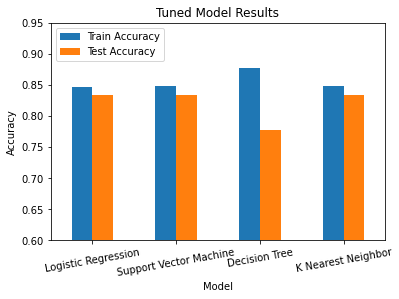

In [37]:
df_results.reset_index().plot(kind='bar',x='index',y=['Train Accuracy','Test Accuracy'],rot=10,title='Tuned Model Results', xlabel='Model', ylabel='Accuracy');
plt.legend(loc='upper left');
plt.ylim([0.6,0.95]);

# Extensions

## Improved cross-validation

To determine the preferred method, we can re-run the analysis with multiple split instances.  It would also be useful to decrease the number of folds to smooth the prediction.

In [38]:
df_results.insert(3,'RKF10x10 Best Parameters',0)
df_results.insert(4,'RKF10x10 Train Accuracy',0)
df_results.insert(5,'RKF10x10 Test Accuracy',0)

LOGISTIC REGRESSION
tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
train accuracy : 0.8230357142857143
test accuracy: 0.8333333333333334


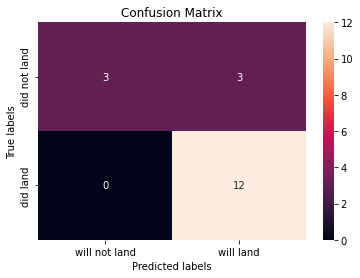

In [39]:
print('LOGISTIC REGRESSION')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'], # l1 lasso l2 ridge
             'solver':['lbfgs'] # ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
            }
est=LogisticRegression()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 0
df_results.iloc[ii,3] = [grid.best_params_]
df_results.iloc[ii,4] = grid.best_score_
df_results.iloc[ii,5] = grid.score(X_test, Y_test)

SUPPORT VECTOR MACHINE
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
train accuracy : 0.8239285714285713
test accuracy: 0.8333333333333334


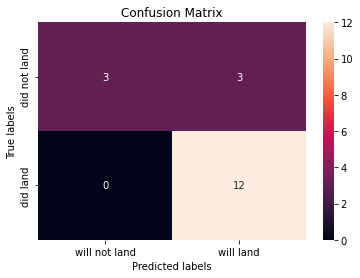

In [40]:
print('SUPPORT VECTOR MACHINE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
est = SVC()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 1
df_results.iloc[ii,3] = [grid.best_params_]
df_results.iloc[ii,4] = grid.best_score_
df_results.iloc[ii,5] = grid.score(X_test, Y_test)

DECISION TREE
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
train accuracy : 0.8273214285714284
test accuracy: 0.8333333333333334


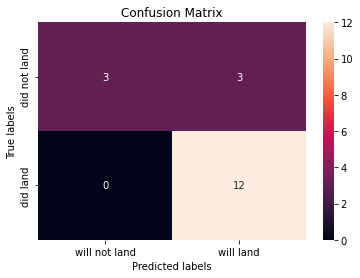

In [41]:
print('DECISION TREE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
est = DecisionTreeClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 2
df_results.iloc[ii,3] = [grid.best_params_]
df_results.iloc[ii,4] = grid.best_score_
df_results.iloc[ii,5] = grid.score(X_test, Y_test)

K NEAREST NEIGHBORS
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}
train accuracy : 0.8435714285714284
test accuracy: 0.8333333333333334


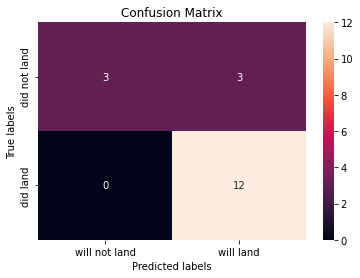

In [42]:
print('K NEAREST NEIGHBORS')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
est = KNeighborsClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 3
df_results.iloc[ii,3] = [grid.best_params_]
df_results.iloc[ii,4] = grid.best_score_
df_results.iloc[ii,5] = grid.score(X_test, Y_test)

Similar results are obtained with this additional cross-validation, except for the Decision Tree which has a significantly better score.  Despite the better Decision Tree score, the apparent accuracy may be due to the random state for the initial test-train split and a form of overfitting (or just luck).  Let's try with another split:

In [43]:
df_results

,Best Parameters,Train Accuracy,Test Accuracy,RKF10x10 Best Parameters,RKF10x10 Train Accuracy,RKF10x10 Test Accuracy
Logistic Regression,"[{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}]",0.846429,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.823036,0.833333
Support Vector Machine,"[{'C': 1.0, 'gamma': 0.03162277660168379, 'ker...",0.848214,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.823929,0.833333
Decision Tree,"[{'criterion': 'gini', 'max_depth': 10, 'max_f...",0.876786,0.777778,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.827321,0.833333
K Nearest Neighbor,"[{'algorithm': 'auto', 'n_neighbors': 10, 'p':...",0.848214,0.833333,"{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}",0.843571,0.833333


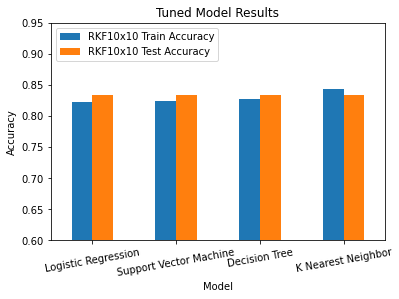

In [44]:
df_results.reset_index().plot(kind='bar',x='index',y=['RKF10x10 Train Accuracy','RKF10x10 Test Accuracy'],rot=10,title='Tuned Model Results', xlabel='Model', ylabel='Accuracy');
plt.legend(loc='upper left');
plt.ylim([0.6,0.95]);

## Alternate Test-Train Split

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [46]:
df_results.insert(6,'TT2 RKF10x10 Best Parameters',0)
df_results.insert(7,'TT2 RKF10x10 Train Accuracy',0)
df_results.insert(8,'TT2 RKF10x10 Test Accuracy',0)

LOGISTIC REGRESSION
tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
train accuracy : 0.8174999999999997
test accuracy: 0.8333333333333334


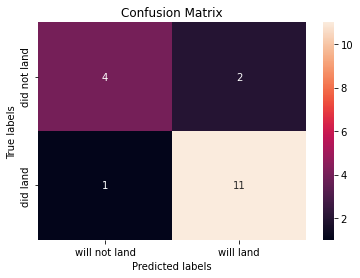

In [47]:
print('LOGISTIC REGRESSION')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'], # l1 lasso l2 ridge
             'solver':['lbfgs'] # ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
            }
est=LogisticRegression()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 0
df_results.iloc[ii,6] = [grid.best_params_]
df_results.iloc[ii,7] = grid.best_score_
df_results.iloc[ii,8] = grid.score(X_test, Y_test)

SUPPORT VECTOR MACHINE
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
train accuracy : 0.8432142857142858
test accuracy: 0.8333333333333334


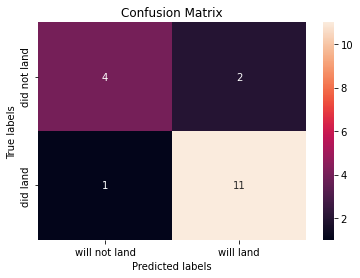

In [48]:
print('SUPPORT VECTOR MACHINE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
est = SVC()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 1
df_results.iloc[ii,6] = [grid.best_params_]
df_results.iloc[ii,7] = grid.best_score_
df_results.iloc[ii,8] = grid.score(X_test, Y_test)

DECISION TREE
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
train accuracy : 0.8533928571428572
test accuracy: 0.8333333333333334


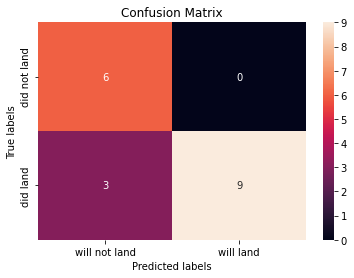

In [49]:
print('DECISION TREE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
est = DecisionTreeClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 2
df_results.iloc[ii,6] = [grid.best_params_]
df_results.iloc[ii,7] = grid.best_score_
df_results.iloc[ii,8] = grid.score(X_test, Y_test)

K NEAREST NEIGHBORS
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}
train accuracy : 0.8505357142857142
test accuracy: 0.7777777777777778


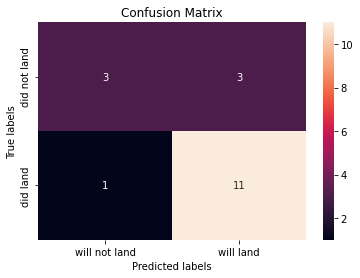

In [50]:
print('K NEAREST NEIGHBORS')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
est = KNeighborsClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 3
df_results.iloc[ii,6] = [grid.best_params_]
df_results.iloc[ii,7] = grid.best_score_
df_results.iloc[ii,8] = grid.score(X_test, Y_test)

This time Decision Tree is worse, indicating overfitting.

Either Logistic Regression or Support Vector Machine is our current choice for model, with slight preference for Support Vector Machine with a higher cross-validation training accuracy score.

In [51]:
df_results

,Best Parameters,Train Accuracy,Test Accuracy,RKF10x10 Best Parameters,RKF10x10 Train Accuracy,RKF10x10 Test Accuracy,TT2 RKF10x10 Best Parameters,TT2 RKF10x10 Train Accuracy,TT2 RKF10x10 Test Accuracy
Logistic Regression,"[{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}]",0.846429,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.823036,0.833333,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.817500,0.833333
Support Vector Machine,"[{'C': 1.0, 'gamma': 0.03162277660168379, 'ker...",0.848214,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.823929,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.843214,0.833333
Decision Tree,"[{'criterion': 'gini', 'max_depth': 10, 'max_f...",0.876786,0.777778,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.827321,0.833333,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.853393,0.833333
K Nearest Neighbor,"[{'algorithm': 'auto', 'n_neighbors': 10, 'p':...",0.848214,0.833333,"{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}",0.843571,0.833333,"{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}",0.850536,0.777778


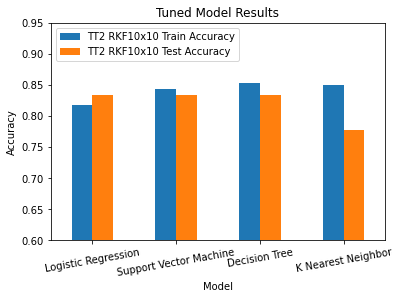

In [52]:
df_results.reset_index().plot(kind='bar',x='index',y=['TT2 RKF10x10 Train Accuracy','TT2 RKF10x10 Test Accuracy'],rot=10,title='Tuned Model Results', xlabel='Model', ylabel='Accuracy');
plt.legend(loc='upper left');
plt.ylim([0.6,0.95]);

## Feature Importance

Not all of the 83 features are likely to be of equal importance.  There are several ways we can narrow down the number of features considered:
* Calculate f-values and for each feature and take only the most predictive
* Perform principal component analysis and retain only those features that explain the most variance

### Principal Component Analysis

One appealing feature of principal component analysis is that it implicitly consolidates covariation among features.

In [53]:
pca = sklearn.decomposition.PCA(random_state=0)
orig_features = X
new_features = pca.fit_transform(orig_features)
X2 = pd.DataFrame(new_features)
X2

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,-4.909343,2.102922,0.215068,-1.788056,-0.332740,-1.363432,-3.117420,1.335301,-1.139545,-1.660355,...,1.959370e-16,-1.158928e-16,-7.965953e-17,1.845706e-16,-1.404906e-17,2.625437e-18,-5.310933e-17,2.790360e-17,-6.294229e-17,3.115643e-17
1,-5.231096,1.823497,0.184240,-2.016151,-0.151100,-1.251304,-2.532254,1.586292,-1.160700,-1.459627,...,1.959370e-16,-1.158928e-16,-7.965953e-17,1.845706e-16,-1.404906e-17,2.625437e-18,-5.310933e-17,2.790360e-17,-6.294229e-17,3.115643e-17
2,-4.945914,1.524776,-0.183703,-1.962335,-0.694782,1.357545,0.094652,-1.054539,0.471459,1.117323,...,1.959370e-16,-1.158928e-16,-7.965953e-17,1.845706e-16,-1.404906e-17,2.625437e-18,-5.310933e-17,2.790360e-17,-6.294229e-17,3.115643e-17
3,-4.489703,1.080003,4.872438,0.012778,-0.175761,0.664685,-0.970878,-1.031542,0.210331,1.146135,...,1.959370e-16,-1.158928e-16,-7.965953e-17,1.845706e-16,-1.404906e-17,2.625437e-18,-5.310933e-17,2.790360e-17,-6.294229e-17,3.115643e-17
4,-4.866301,2.656031,0.124340,0.446506,-0.757102,0.826351,0.047929,0.594808,-0.607095,0.273395,...,1.959370e-16,-1.158928e-16,-7.965953e-17,1.845706e-16,-1.404906e-17,2.625437e-18,-5.310933e-17,2.790360e-17,-6.294229e-17,3.115643e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,3.820074,1.302023,-0.609078,0.961651,0.027758,-1.341097,-0.650355,-1.228095,1.045781,-1.179363,...,-5.469054e-16,-3.848663e-16,-1.280126e-16,4.752837e-16,-2.010211e-17,6.322834e-16,2.085512e-16,-2.310937e-16,1.945347e-16,-7.698012e-18
86,4.033917,1.412252,-0.751568,1.017746,0.814609,-0.687432,-0.899839,-1.494563,1.399952,-0.246326,...,-4.552631e-16,3.118719e-16,-1.369304e-16,-6.407865e-17,-1.530202e-17,7.348105e-16,-3.460559e-16,-1.595565e-16,-1.466790e-16,4.707545e-16
87,5.402497,2.363366,-0.630134,0.360010,1.115612,0.636320,-1.211306,-0.301518,0.557947,-1.235797,...,4.293759e-15,-7.768868e-16,4.351721e-16,8.491562e-17,-2.703211e-17,2.957693e-16,-5.472707e-17,-6.142414e-16,-3.052691e-16,-3.938479e-17
88,3.662205,0.979466,0.381161,-0.596499,-2.289190,-1.549295,-0.868769,-0.854964,0.691212,-0.731205,...,9.387795e-16,1.530806e-16,-3.130650e-17,-1.061425e-16,-7.996004e-18,-6.270325e-16,-3.147699e-16,2.869009e-16,-3.204193e-16,7.001088e-17


We plot the cumulative explained variance normalized by the total explained variance as a function of how many components are included:

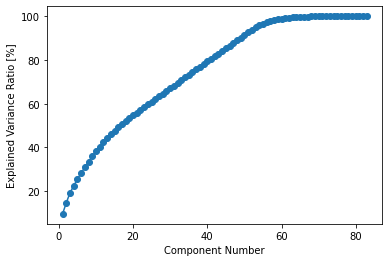

In [54]:
plt.plot([1+x for x in range(len(pca.explained_variance_ratio_))],np.cumsum(pca.explained_variance_ratio_) * 100,marker='o')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio [%]');

The knee of decreasing marginal explained variance increase is at 55-60 components.  We re-run the analysis first for all components:

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y, test_size=0.2, random_state=2)

In [56]:
df_results.insert(9,'PCA RKF10x10 Best Parameters',0)
df_results.insert(10,'PCA RKF10x10 Train Accuracy',0)
df_results.insert(11,'PCA RKF10x10 Test Accuracy',0)

LOGISTIC REGRESSION
tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
train accuracy : 0.8230357142857143
test accuracy: 0.8333333333333334


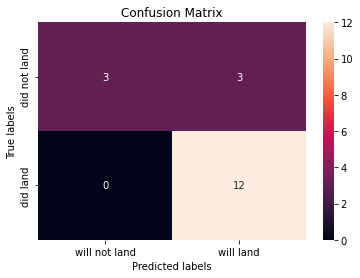

In [57]:
print('LOGISTIC REGRESSION')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'], # l1 lasso l2 ridge
             'solver':['lbfgs'] # ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
            }
est=LogisticRegression()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 0
df_results.iloc[ii,9] = [grid.best_params_]
df_results.iloc[ii,10] = grid.best_score_
df_results.iloc[ii,11] = grid.score(X_test, Y_test)

SUPPORT VECTOR MACHINE
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
train accuracy : 0.8239285714285713
test accuracy: 0.8333333333333334


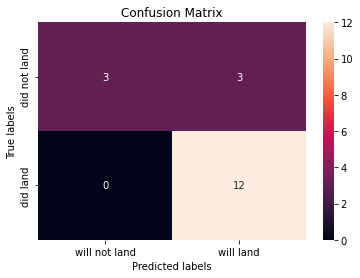

In [58]:
print('SUPPORT VECTOR MACHINE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
est = SVC()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 1
df_results.iloc[ii,9] = [grid.best_params_]
df_results.iloc[ii,10] = grid.best_score_
df_results.iloc[ii,11] = grid.score(X_test, Y_test)

DECISION TREE
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
train accuracy : 0.7391071428571427
test accuracy: 0.6111111111111112


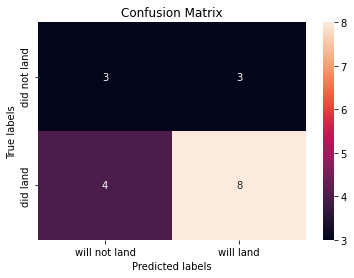

In [59]:
print('DECISION TREE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
est = DecisionTreeClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 2
df_results.iloc[ii,9] = [grid.best_params_]
df_results.iloc[ii,10] = grid.best_score_
df_results.iloc[ii,11] = grid.score(X_test, Y_test)

K NEAREST NEIGHBORS
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}
train accuracy : 0.8091071428571428
test accuracy: 0.7777777777777778


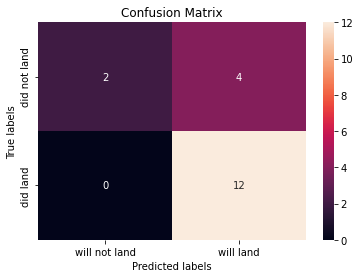

In [60]:
print('K NEAREST NEIGHBORS')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
est = KNeighborsClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 3
df_results.iloc[ii,9] = [grid.best_params_]
df_results.iloc[ii,10] = grid.best_score_
df_results.iloc[ii,11] = grid.score(X_test, Y_test)

This time Decision Tree is worse, indicating overfitting.

Either Logistic Regression or Support Vector Machine is our current choice for model, with slight preference for Support Vector Machine with a higher cross-validation training accuracy score.

In [61]:
df_results

,Best Parameters,Train Accuracy,Test Accuracy,RKF10x10 Best Parameters,RKF10x10 Train Accuracy,RKF10x10 Test Accuracy,TT2 RKF10x10 Best Parameters,TT2 RKF10x10 Train Accuracy,TT2 RKF10x10 Test Accuracy,PCA RKF10x10 Best Parameters,PCA RKF10x10 Train Accuracy,PCA RKF10x10 Test Accuracy
Logistic Regression,"[{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}]",0.846429,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.823036,0.833333,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.817500,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.823036,0.833333
Support Vector Machine,"[{'C': 1.0, 'gamma': 0.03162277660168379, 'ker...",0.848214,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.823929,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.843214,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.823929,0.833333
Decision Tree,"[{'criterion': 'gini', 'max_depth': 10, 'max_f...",0.876786,0.777778,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.827321,0.833333,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.853393,0.833333,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.739107,0.611111
K Nearest Neighbor,"[{'algorithm': 'auto', 'n_neighbors': 10, 'p':...",0.848214,0.833333,"{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}",0.843571,0.833333,"{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}",0.850536,0.777778,"{'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}",0.809107,0.777778


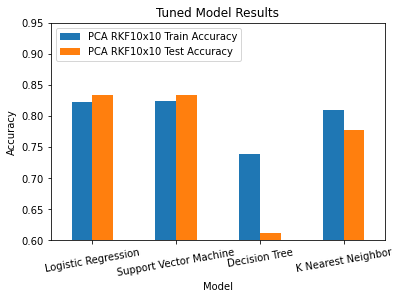

In [62]:
df_results.reset_index().plot(kind='bar',x='index',y=['PCA RKF10x10 Train Accuracy','PCA RKF10x10 Test Accuracy'],rot=10,title='Tuned Model Results', xlabel='Model', ylabel='Accuracy');
plt.legend(loc='upper left');
plt.ylim([0.6,0.95]);

Next we re-run for the 55 most important components:

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X2.loc[:,0:55], Y, test_size=0.2, random_state=2)

In [64]:
dfinds = [12, 13, 14]

In [65]:
df_results.insert(dfinds[0],'PCA(55) RKF10x10 Best Parameters',0)
df_results.insert(dfinds[1],'PCA(55) RKF10x10 Train Accuracy',0)
df_results.insert(dfinds[2],'PCA(55) RKF10x10 Test Accuracy',0)

LOGISTIC REGRESSION
tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
train accuracy : 0.8257142857142857
test accuracy: 0.8333333333333334


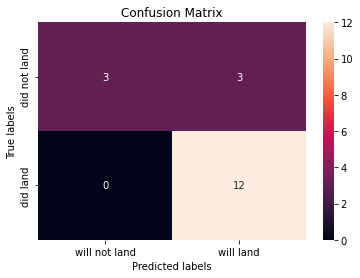

In [66]:
print('LOGISTIC REGRESSION')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'], # l1 lasso l2 ridge
             'solver':['lbfgs'] # ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
            }
est=LogisticRegression()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 0
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

SUPPORT VECTOR MACHINE
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
train accuracy : 0.8294642857142855
test accuracy: 0.8333333333333334


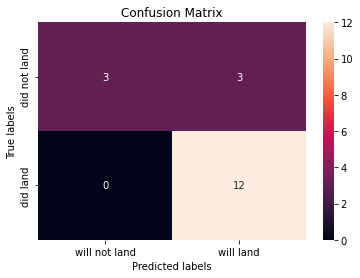

In [67]:
print('SUPPORT VECTOR MACHINE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
est = SVC()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 1
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

DECISION TREE
tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
train accuracy : 0.7507142857142856
test accuracy: 0.6111111111111112


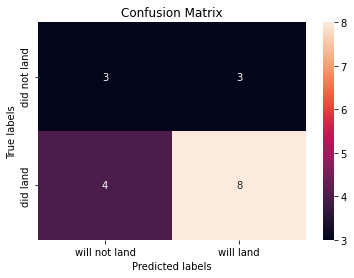

In [68]:
print('DECISION TREE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
est = DecisionTreeClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 2
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

K NEAREST NEIGHBORS
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}
train accuracy : 0.8373214285714284
test accuracy: 0.7777777777777778


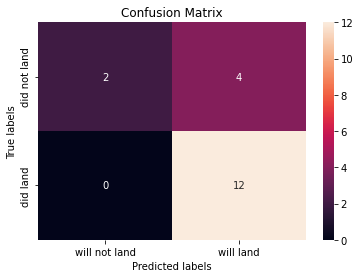

In [69]:
print('K NEAREST NEIGHBORS')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
est = KNeighborsClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 3
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

This time Decision Tree and K Nearest Neighbors suffer.

Either Logistic Regression or Support Vector Machine is our current choice for model, with slight preference for Support Vector Machine with a higher cross-validation training accuracy score.

In [70]:
df_results

,Best Parameters,Train Accuracy,Test Accuracy,RKF10x10 Best Parameters,RKF10x10 Train Accuracy,RKF10x10 Test Accuracy,TT2 RKF10x10 Best Parameters,TT2 RKF10x10 Train Accuracy,TT2 RKF10x10 Test Accuracy,PCA RKF10x10 Best Parameters,PCA RKF10x10 Train Accuracy,PCA RKF10x10 Test Accuracy,PCA(55) RKF10x10 Best Parameters,PCA(55) RKF10x10 Train Accuracy,PCA(55) RKF10x10 Test Accuracy
Logistic Regression,"[{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}]",0.846429,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.823036,0.833333,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.817500,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.823036,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.825714,0.833333
Support Vector Machine,"[{'C': 1.0, 'gamma': 0.03162277660168379, 'ker...",0.848214,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.823929,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.843214,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.823929,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.829464,0.833333
Decision Tree,"[{'criterion': 'gini', 'max_depth': 10, 'max_f...",0.876786,0.777778,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.827321,0.833333,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.853393,0.833333,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.739107,0.611111,"{'criterion': 'gini', 'max_depth': 18, 'max_fe...",0.750714,0.611111
K Nearest Neighbor,"[{'algorithm': 'auto', 'n_neighbors': 10, 'p':...",0.848214,0.833333,"{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}",0.843571,0.833333,"{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}",0.850536,0.777778,"{'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}",0.809107,0.777778,"{'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}",0.837321,0.777778


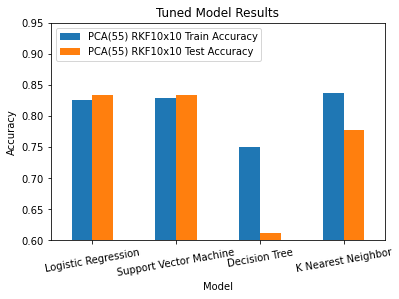

In [71]:
df_results.reset_index().plot(kind='bar',x='index',y=list(df_results.columns[dfinds][1:3]),rot=10,title='Tuned Model Results', xlabel='Model', ylabel='Accuracy');
plt.legend(loc='upper left');
plt.ylim([0.6,0.95]);

Next we re-run for the 17 most important components comprising 50% of explained variance:

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(X2.loc[:,0:17], Y, test_size=0.2, random_state=2)

In [73]:
dfinds = [15, 16, 17]

In [74]:
df_results.insert(dfinds[0],'PCA(17) RKF10x10 Best Parameters',0)
df_results.insert(dfinds[1],'PCA(17) RKF10x10 Train Accuracy',0)
df_results.insert(dfinds[2],'PCA(17) RKF10x10 Test Accuracy',0)

LOGISTIC REGRESSION
tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
train accuracy : 0.8182142857142856
test accuracy: 0.8333333333333334


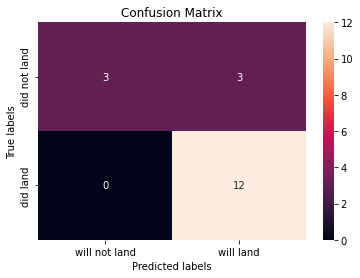

In [75]:
print('LOGISTIC REGRESSION')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'], # l1 lasso l2 ridge
             'solver':['lbfgs'] # ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
            }
est=LogisticRegression()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 0
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

SUPPORT VECTOR MACHINE
tuned hpyerparameters :(best parameters)  {'C': 0.03162277660168379, 'gamma': 0.001, 'kernel': 'linear'}
train accuracy : 0.833392857142857
test accuracy: 0.8333333333333334


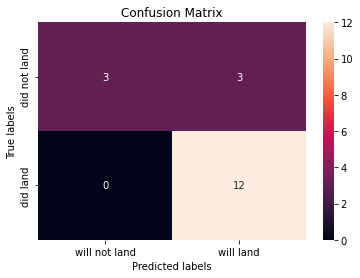

In [76]:
print('SUPPORT VECTOR MACHINE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
est = SVC()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 1
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

DECISION TREE
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
train accuracy : 0.7566071428571429
test accuracy: 0.5555555555555556


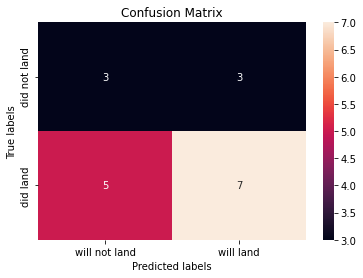

In [77]:
print('DECISION TREE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
est = DecisionTreeClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 2
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

K NEAREST NEIGHBORS
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}
train accuracy : 0.8667857142857143
test accuracy: 0.7222222222222222


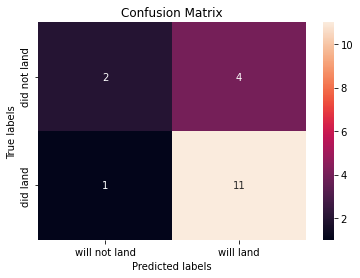

In [78]:
print('K NEAREST NEIGHBORS')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
est = KNeighborsClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 3
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

This time Decision Tree and K Nearest Neighbors suffer even more, but it is interesting that Logistic Regression and Support Vector Machine maintain the same test accuracy.

Either Logistic Regression or Support Vector Machine is our current choice for model, with slight preference for Support Vector Machine with a higher cross-validation training accuracy score.

In [79]:
df_results

,Best Parameters,Train Accuracy,Test Accuracy,RKF10x10 Best Parameters,RKF10x10 Train Accuracy,RKF10x10 Test Accuracy,TT2 RKF10x10 Best Parameters,TT2 RKF10x10 Train Accuracy,TT2 RKF10x10 Test Accuracy,PCA RKF10x10 Best Parameters,PCA RKF10x10 Train Accuracy,PCA RKF10x10 Test Accuracy,PCA(55) RKF10x10 Best Parameters,PCA(55) RKF10x10 Train Accuracy,PCA(55) RKF10x10 Test Accuracy,PCA(17) RKF10x10 Best Parameters,PCA(17) RKF10x10 Train Accuracy,PCA(17) RKF10x10 Test Accuracy
Logistic Regression,"[{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}]",0.846429,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.823036,0.833333,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.817500,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.823036,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.825714,0.833333,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.818214,0.833333
Support Vector Machine,"[{'C': 1.0, 'gamma': 0.03162277660168379, 'ker...",0.848214,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.823929,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.843214,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.823929,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.829464,0.833333,"{'C': 0.03162277660168379, 'gamma': 0.001, 'ke...",0.833393,0.833333
Decision Tree,"[{'criterion': 'gini', 'max_depth': 10, 'max_f...",0.876786,0.777778,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.827321,0.833333,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.853393,0.833333,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.739107,0.611111,"{'criterion': 'gini', 'max_depth': 18, 'max_fe...",0.750714,0.611111,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.756607,0.555556
K Nearest Neighbor,"[{'algorithm': 'auto', 'n_neighbors': 10, 'p':...",0.848214,0.833333,"{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}",0.843571,0.833333,"{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}",0.850536,0.777778,"{'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}",0.809107,0.777778,"{'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}",0.837321,0.777778,"{'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}",0.866786,0.722222


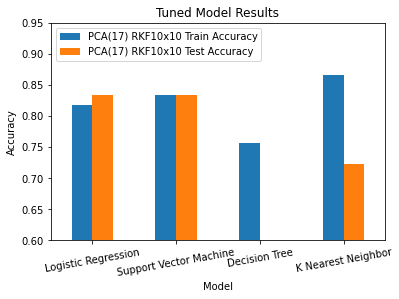

In [80]:
df_results.reset_index().plot(kind='bar',x='index',y=list(df_results.columns[dfinds][1:3]),rot=10,title='Tuned Model Results', xlabel='Model', ylabel='Accuracy');
plt.legend(loc='upper left');
plt.ylim([0.6,0.95]);

### Feature importance of original features

First we examine the p-values of our current features:

In [81]:
f = sklearn.feature_selection.f_classif(X, Y)

In [82]:
df_f = pd.DataFrame(f, columns=features.columns, index=['F-Statistic','P-Value']).T.sort_values('P-Value')
pd.set_option('display.max_rows', None)
df_f

,F-Statistic,P-Value
Legs_True,7.318398e+01,3.383519e-13
Legs_False,7.318398e+01,3.383519e-13
GridFins_True,6.187835e+01,8.683107e-12
GridFins_False,6.187835e+01,8.683107e-12
ReusedCount,2.448886e+01,3.564904e-06
Block,1.841751e+01,4.543415e-05
FlightNumber,1.695454e+01,8.615393e-05
LandingPad_5e9e3032383ecb6bb234e7ca,1.020290e+01,1.946502e-03
LandingPad_5e9e3032383ecb267a34e7c7,4.626709e+00,3.421866e-02
LandingPad_5e9e3032383ecb761634e7cb,4.190476e+00,4.363427e-02


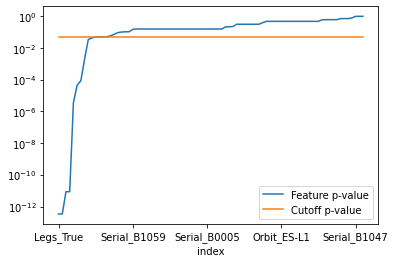

In [83]:
df_f.reset_index().plot(x='index',y='P-Value',logy=True,label='Feature p-value')
plt.plot([0,82],[0.05,0.05],label='Cutoff p-value')
plt.legend();

In [84]:
threshold = 0.05
print('There are',sum(df_f['P-Value']<threshold),f'features significant at the p={threshold} level')
df_f.loc[df_f['P-Value']<threshold,:]

There are 13 features significant at the p=0.05 level


,F-Statistic,P-Value
Legs_True,73.183978,3.383519e-13
Legs_False,73.183978,3.383519e-13
GridFins_True,61.878345,8.683107e-12
GridFins_False,61.878345,8.683107e-12
ReusedCount,24.488856,3.564904e-06
Block,18.417512,4.543415e-05
FlightNumber,16.954541,8.615393e-05
LandingPad_5e9e3032383ecb6bb234e7ca,10.202899,1.946502e-03
LandingPad_5e9e3032383ecb267a34e7c7,4.626709,3.421866e-02
LandingPad_5e9e3032383ecb761634e7cb,4.190476,4.363427e-02


Next we fit to just these features; again we expect there to be no improvement in the maximum predictive accuracy.

In [85]:
cols = df_f.loc[df_f['P-Value']<threshold,:].index

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(X[:,[x in cols for x in features.columns]], Y, test_size=0.2, random_state=2)

In [87]:
dfinds = [18, 19, 20]

In [88]:
df_results.insert(dfinds[0],'P-Value(13) RKF10x10 Best Parameters',0)
df_results.insert(dfinds[1],'P-Value(13) RKF10x10 Train Accuracy',0)
df_results.insert(dfinds[2],'P-Value(13) RKF10x10 Test Accuracy',0)

LOGISTIC REGRESSION
tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
train accuracy : 0.832142857142857
test accuracy: 0.8333333333333334
Wall time: 1.27 s


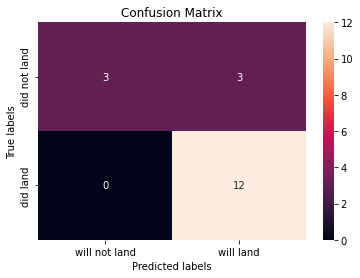

In [89]:
%%time
print('LOGISTIC REGRESSION')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'], # l1 lasso l2 ridge
             'solver':['lbfgs'] # ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
            }
est=LogisticRegression()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 0
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

SUPPORT VECTOR MACHINE
tuned hpyerparameters :(best parameters)  {'C': 31.622776601683793, 'gamma': 31.622776601683793, 'kernel': 'rbf'}
train accuracy : 0.8819642857142856
test accuracy: 0.8333333333333334
Wall time: 2min 30s


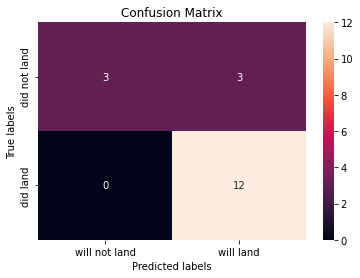

In [90]:
%%time
print('SUPPORT VECTOR MACHINE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
est = SVC()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 1
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

DECISION TREE
tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
train accuracy : 0.8576785714285714
test accuracy: 0.7777777777777778
Wall time: 1min 27s


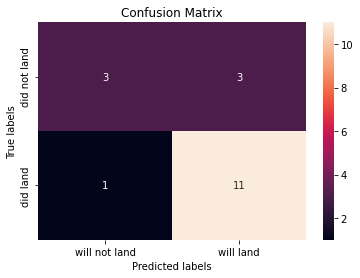

In [91]:
%%time
print('DECISION TREE')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
est = DecisionTreeClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 2
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

K NEAREST NEIGHBORS
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2}
train accuracy : 0.8673214285714286
test accuracy: 0.8333333333333334
Wall time: 15.3 s


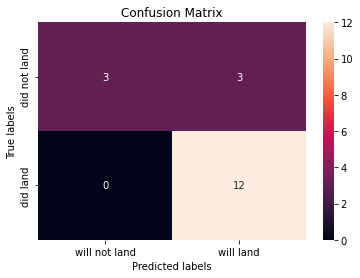

In [92]:
%%time
print('K NEAREST NEIGHBORS')
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2)
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
est = KNeighborsClassifier()
grid = GridSearchCV(estimator=est, param_grid=parameters, scoring=None, n_jobs=1, cv=cv)
grid.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("train accuracy :",grid.best_score_)
print("test accuracy:",grid.score(X_test, Y_test))
yhat=grid.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
ii = 3
df_results.iloc[ii,dfinds[0]] = [grid.best_params_]
df_results.iloc[ii,dfinds[1]] = grid.best_score_
df_results.iloc[ii,dfinds[2]] = grid.score(X_test, Y_test)

This time only the Decision Tree is suboptimal, but note that training set fits are the best yet, indicating potential for better fitting.

In [93]:
df_results

,Best Parameters,Train Accuracy,Test Accuracy,RKF10x10 Best Parameters,RKF10x10 Train Accuracy,RKF10x10 Test Accuracy,TT2 RKF10x10 Best Parameters,TT2 RKF10x10 Train Accuracy,TT2 RKF10x10 Test Accuracy,PCA RKF10x10 Best Parameters,...,PCA RKF10x10 Test Accuracy,PCA(55) RKF10x10 Best Parameters,PCA(55) RKF10x10 Train Accuracy,PCA(55) RKF10x10 Test Accuracy,PCA(17) RKF10x10 Best Parameters,PCA(17) RKF10x10 Train Accuracy,PCA(17) RKF10x10 Test Accuracy,P-Value(13) RKF10x10 Best Parameters,P-Value(13) RKF10x10 Train Accuracy,P-Value(13) RKF10x10 Test Accuracy
Logistic Regression,"[{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}]",0.846429,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.823036,0.833333,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.817500,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",...,0.833333,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.825714,0.833333,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.818214,0.833333,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.832143,0.833333
Support Vector Machine,"[{'C': 1.0, 'gamma': 0.03162277660168379, 'ker...",0.848214,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.823929,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.843214,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",...,0.833333,"{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.829464,0.833333,"{'C': 0.03162277660168379, 'gamma': 0.001, 'ke...",0.833393,0.833333,"{'C': 31.622776601683793, 'gamma': 31.62277660...",0.881964,0.833333
Decision Tree,"[{'criterion': 'gini', 'max_depth': 10, 'max_f...",0.876786,0.777778,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.827321,0.833333,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.853393,0.833333,"{'criterion': 'entropy', 'max_depth': 10, 'max...",...,0.611111,"{'criterion': 'gini', 'max_depth': 18, 'max_fe...",0.750714,0.611111,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.756607,0.555556,"{'criterion': 'gini', 'max_depth': 12, 'max_fe...",0.857679,0.777778
K Nearest Neighbor,"[{'algorithm': 'auto', 'n_neighbors': 10, 'p':...",0.848214,0.833333,"{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}",0.843571,0.833333,"{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}",0.850536,0.777778,"{'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}",...,0.777778,"{'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}",0.837321,0.777778,"{'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}",0.866786,0.722222,"{'algorithm': 'auto', 'n_neighbors': 1, 'p': 2}",0.867321,0.833333


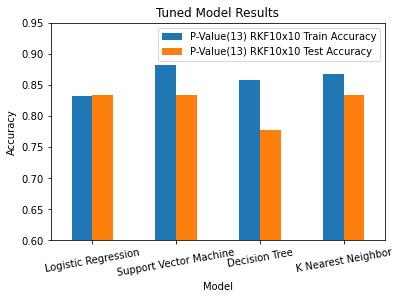

In [94]:
df_results.reset_index().plot(kind='bar',x='index',y=list(df_results.columns[dfinds][1:3]),rot=10,title='Tuned Model Results', xlabel='Model', ylabel='Accuracy');
plt.legend(loc='upper right');
plt.ylim([0.60,.95]);

Again Logistic Regression and Support Vector Machine maintain their unbroken lead in prediction accuracy, but Support Vector Machine has the highest training accuracy yet, so we prefer this model.  Note however that the training time is different for the various models, and this could come be a factor in a production environment.

## Future Work: Feature Improvement

Some features were inconsiderately split, and rectifying this can improve the succinctness of the models:
* GridFins, Legs, Reused should not be one-hot encoded as they are already binary variables
* Serial should be a continuous variable; it is probably covered by FlightNumber, Block, and Reused

Additional features may potentially improve the accuracy of the models:
* Orbit should be broken into Equatorial (boolean), and MeanOrbitHeight (float) as these are more mission-descriptive and capture similarities between categories

Multiple test/train splits should be considered to evaluate the robustness of various models to new data.

## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2021-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

<a href="https://www.linkedin.com/in/daniel-nezich-2990ab16/">Daniel Nezich</a> has a PhD in Physics, his research focused on electronics of low-dimensional materials, high-temperature material growth, and laboratory system design.  Daniel has completed a postdoc and worked for Bluestone Global Tech and MIT Lincoln Laboratory since he completed his PhD.

## Change Log


| Date (YYYY-MM-DD) | Version | Changed By    | Change Description      |
| ----------------- | ------- | ------------- | ----------------------- |
| 2021-09-24        | 1.2     | Daniel Nezich | Completed contents and extensions |
| 2021-08-31        | 1.1     | Lakshmi Holla | Modified markdown       |
| 2020-09-20        | 1.0     | Joseph        | Modified Multiple Areas |


Template Copyright © 2020 IBM Corporation. All rights reserved.
Additions Copyright © 2021 Daniel Nezich. All rights reserved.